In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import time
import scipy.special as special
from scipy.integrate import quad, dblquad, fixed_quad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'

In [2]:
# EVERYTHING IS 1 units

#constants
#e        = 1.     #electron charge
#m        = 1.     #electron mass
#c        = 1.     #speed of light
#epsilon0 = 1.     #permittivity of free space
epsilon0  = 1./(4. * np.pi)
e = 4.80320680e-10
m = 9.1093826e-28
c = 2.99792458e10

epsilon  = -1.    #sign of electron charge

#parameters
B       = 1.         #background B strength
n_e     = 1.         #electron number density cm^-3
theta_e = 0.5         #dimensionless electron temp
theta   = np.pi/3.    #observer angle

#derived quantities
omega_p = np.sqrt(n_e * e**2. / (m * epsilon0))     # plasma frequency    (=1 in these units)
omega_c = e * B / (m * c)                           # cyclotron frequency (=1 in these units)

In [3]:
def K_12_prefactor(omega):
    prefactor = - 1. * omega_p**2. / (omega * omega) * 1./(4. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_12_integrand(gamma, cos_xi, tau_prime, omega):    
    prefactor  = 1j
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp  = p_perp_bar / gamma
    beta_z     = p_z_bar    / gamma
    b          = omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta_perp
    
    term1 = p_perp_bar**2. / gamma**2. * np.exp(-gamma/theta_e)
    term2 = np.exp(1j * (1. - beta_z * np.cos(theta)) * tau_prime)
    term3 = np.sin((epsilon * omega_c / omega) * tau_prime / gamma) * special.j0(2. * b * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma)))
    ans   = prefactor * term1 * term2 * term3
    return ans * gamma**2. * beta 

def K_32_prefactor(omega):
    prefactor = omega_p**2. / (omega * omega) * 1./(2. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_32_integrand(gamma, cos_xi, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp = p_perp_bar / gamma
    beta_z    = p_z_bar    / gamma
    b         = omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta_perp
    
    term1 = p_perp_bar * p_z_bar / gamma**2. * np.exp(-gamma/theta_e)
    term2 = np.exp(1j * (1. - beta_z * np.cos(theta)) * tau_prime)
    term3 = np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma)) * special.jn(1, 2. * b * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma)))
    ans   = prefactor * term1 * term2 * term3
    return ans * gamma**2. * beta

In [4]:
def n_loc(n, tau_prime, gamma):
    if(gamma == 1.):
        return np.sign(1. - n*np.pi/tau_prime)
    
    beta   = np.sqrt(1. - 1./gamma**2.)
    ans = (1. - n*np.pi/tau_prime)/(beta * np.cos(theta))    
    
    if(ans > 1.):
        return 1.
    if(ans < -1.):
        return -1.
    
    return ans

def K_12_xi_integrator(gamma, tau_prime, omega):
    if(tau_prime == 0.):
        return 0.
    
    beta   = np.sqrt(1. - 1./gamma**2.)
    n_min  = - int(tau_prime/np.pi * (-1. + beta * np.cos(theta)))
    n_max  =   int(tau_prime/np.pi * (1. + beta * np.cos(theta)))
    
    ans = 0.
    
    ans    = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, 
                      n_loc(n_max, tau_prime, gamma), -1.)[0]
    
    ans   += quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, 
                      1., n_loc(n_min, tau_prime, gamma))[0]
    
    for i in range(n_min, n_max):
        #print range(n_min, n_max)
#        print n_loc(i, gamma, tau_prime), n_loc(i+1, gamma, tau_prime)
        ans += quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, 
                    n_loc(i, tau_prime, gamma), n_loc(i+1, tau_prime, gamma))[0]
    return -ans

def K_12_xi_integrated(gamma, tau_prime, omega):
    real_part = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)[0]
    return real_part

In [33]:
gamma = np.linspace(1., 5., 300)
omega  = 1000.*omega_c
tau    = 450.

integrator = np.vectorize(K_12_xi_integrator)(gamma, tau, omega)
integrated = np.vectorize(K_12_xi_integrated)(gamma, tau, omega)

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


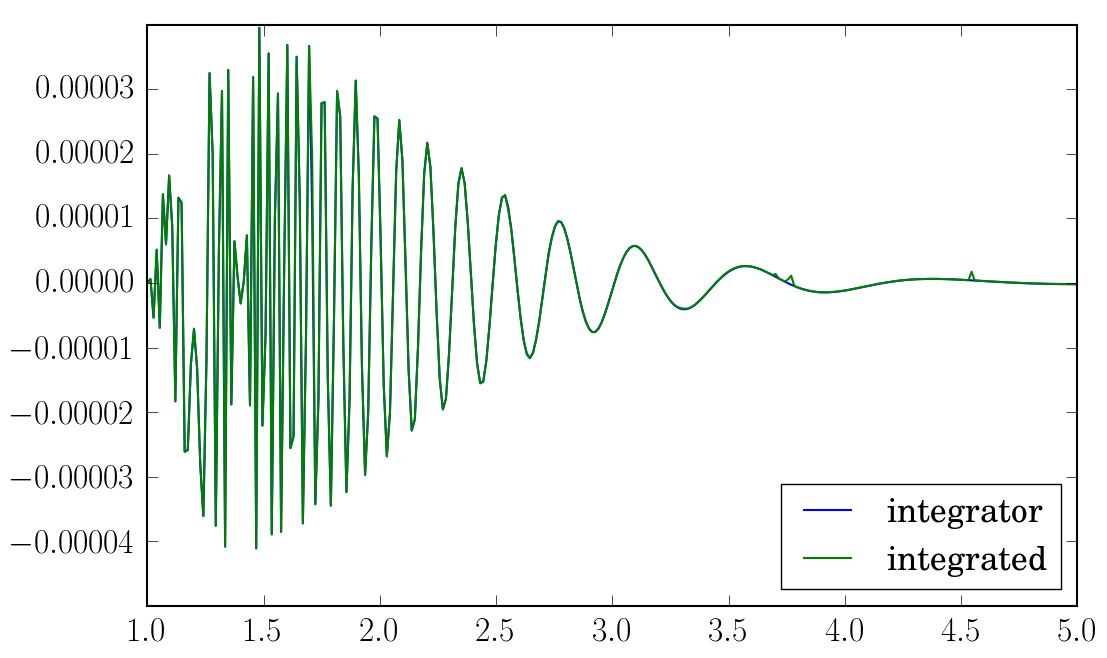

/home/alex/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


(-1.0, 1.0)

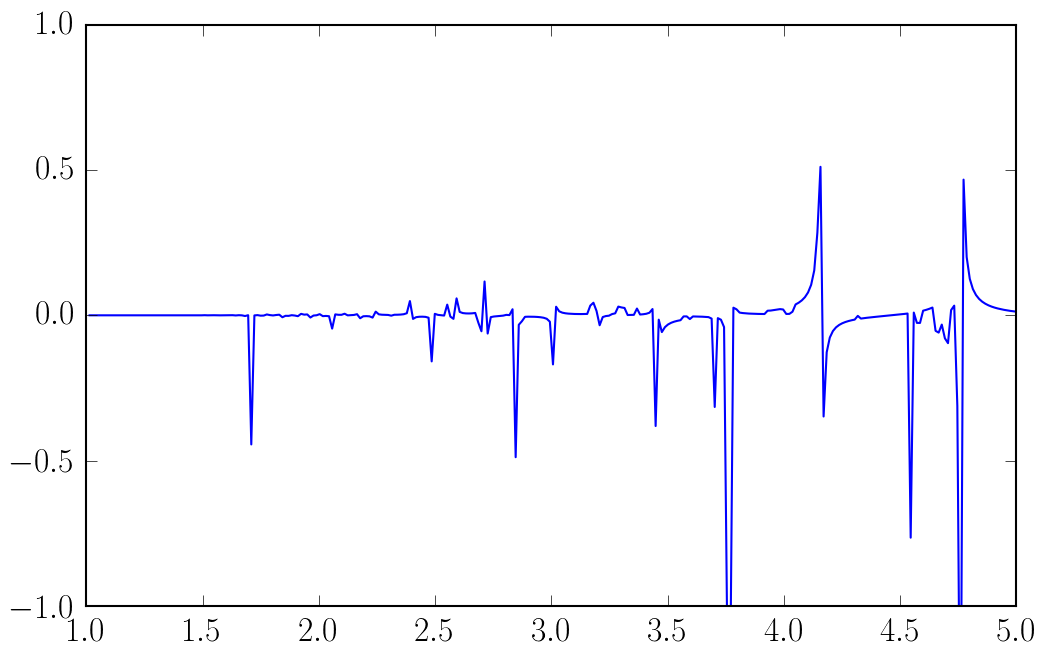

In [34]:
pl.plot(gamma, integrator, label='integrator')
pl.plot(gamma, integrated, label='integrated')

#pl.xlim([1., 3.])
#pl.ylim([-0.00000001, 0.00000001])
pl.legend(loc='lower right')
pl.show()
pl.plot(gamma, integrator/integrated - 1.)
pl.ylim([-1., 1.])

In [215]:
def K_12_p_integrator(tau_prime, omega):
    real_part = quad(lambda gamma: K_12_xi_integrator(gamma, tau_prime, omega), 1., np.inf)[0]
    return real_part

In [216]:
def K_12_p_integrated(tau_prime, omega):
    real_part = dblquad(lambda gamma, cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, 
                       -1, 1, lambda x: 1., lambda x: np.inf)
    ans = real_part[0]
    return ans


def K_32_p_integrated(tau_prime, omega):
    real_part = dblquad(lambda gamma, cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).real, 
                       -1, 1, lambda x: 1., lambda x: np.inf)
    ans = real_part[0]
    return ans

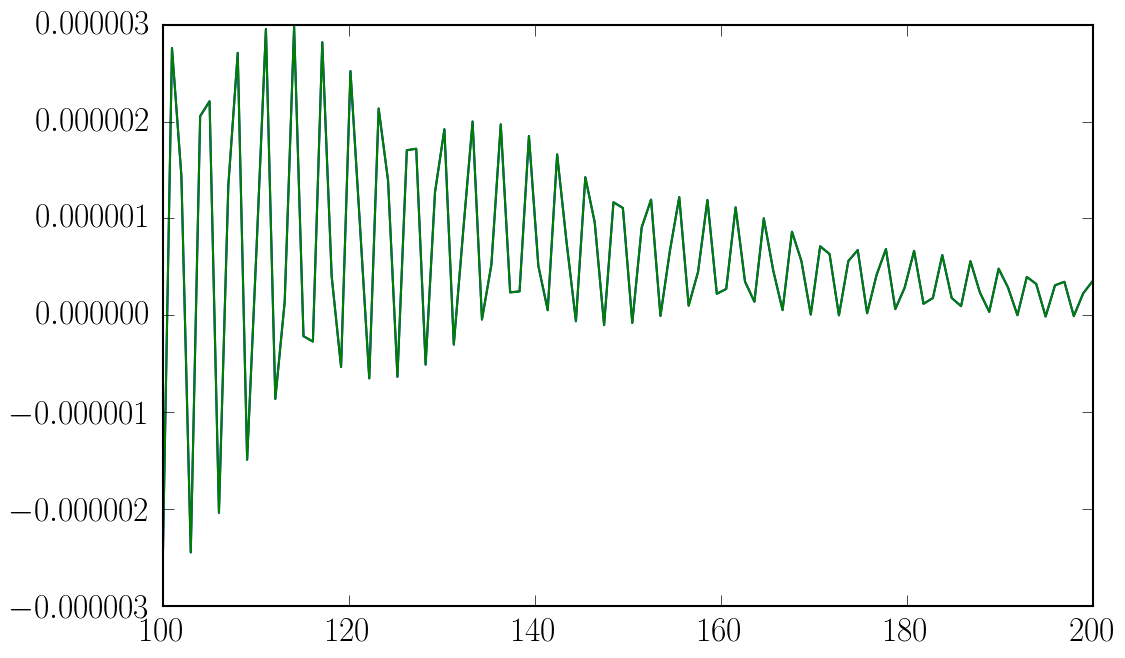

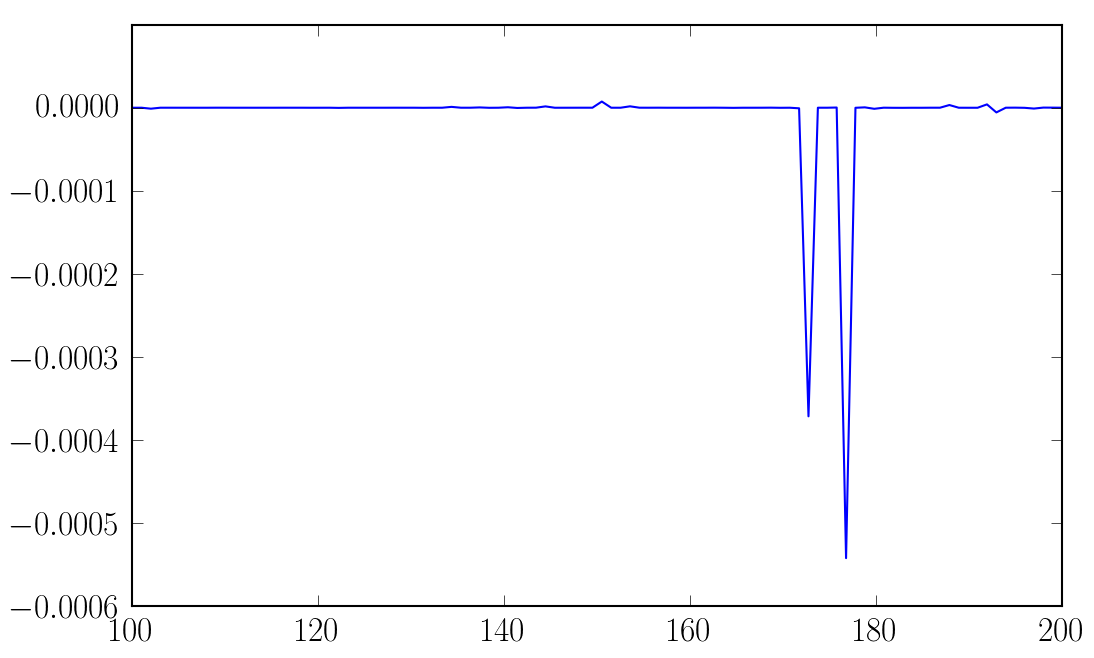

In [217]:
omega = 100. * omega_c
tau   = np.linspace(100., 200., 100)

integrator = np.vectorize(K_12_p_integrator)(tau, omega)
integrated = np.vectorize(K_12_p_integrated)(tau, omega)
pl.plot(tau, integrator)
pl.plot(tau, integrated)
#pl.xlim([20., 25.])
#pl.ylim([-0.001, -0.0005])
pl.show()

pl.plot(tau, integrator/integrated - 1.)

In [225]:
time_before = time.time()

tau_prime = np.linspace(0., 30., 100)

nuratio = 1000.

data = np.vectorize(K_12_p_integrator)(tau_prime, nuratio*omega_c)
time_after  = time.time()
print 'time elapsed: ', time_after - time_before

time elapsed:  15.5736920834


In [10]:
time_before = time.time()
K_12 = fixed_quad(lambda tau: np.vectorize(K_12_p_integrated)(tau, omega_c), 0., 30., n=45)[0]
K_32 = fixed_quad(lambda tau: np.vectorize(K_32_p_integrated)(tau, omega_c), 0., 30., n=45)[0]
time_after  = time.time()
print 'time elapsed: ', time_after - time_before

ans = K_12 * K_12_prefactor(omega_c) * np.cos(theta) + K_32 * K_32_prefactor(omega_c) * np.sin(theta)
print 1./c * ans * omega_c

time elapsed:  11.2886059284
6.48224953213e-10
